## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp003'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

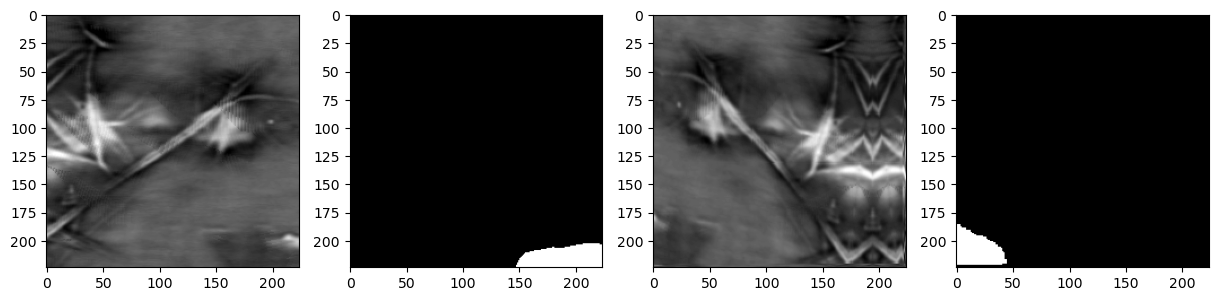

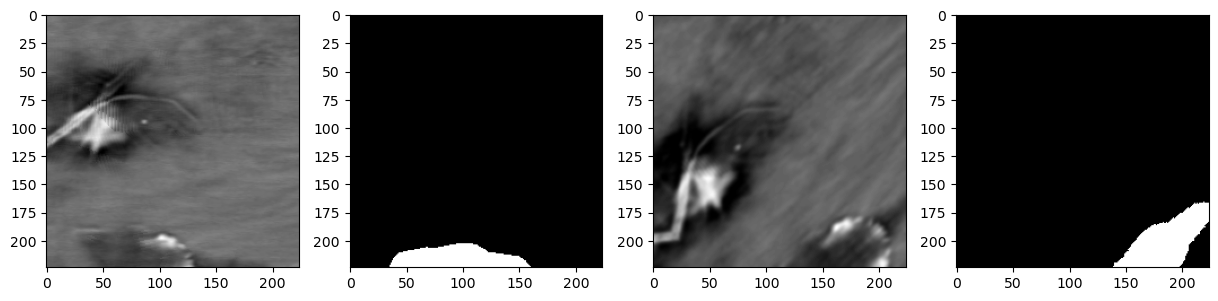

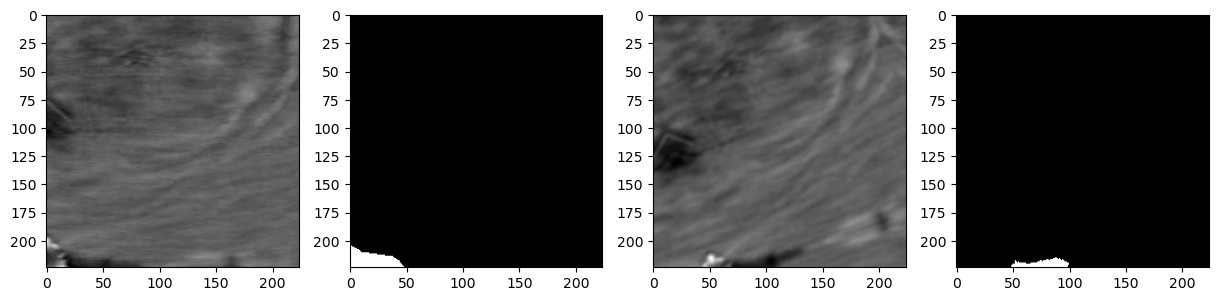

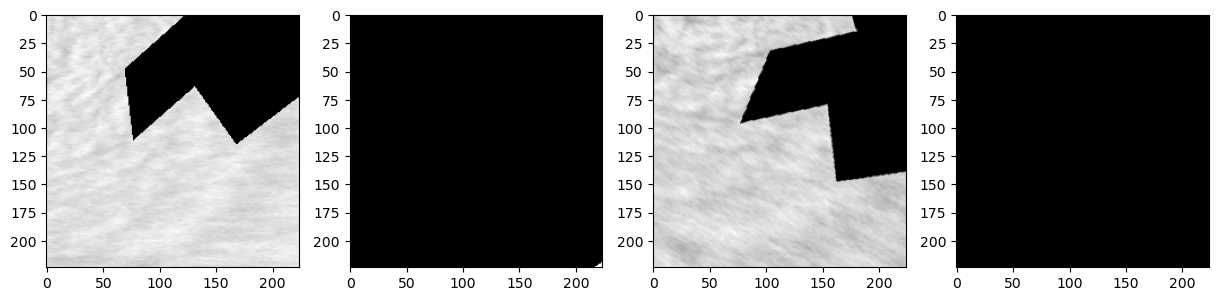

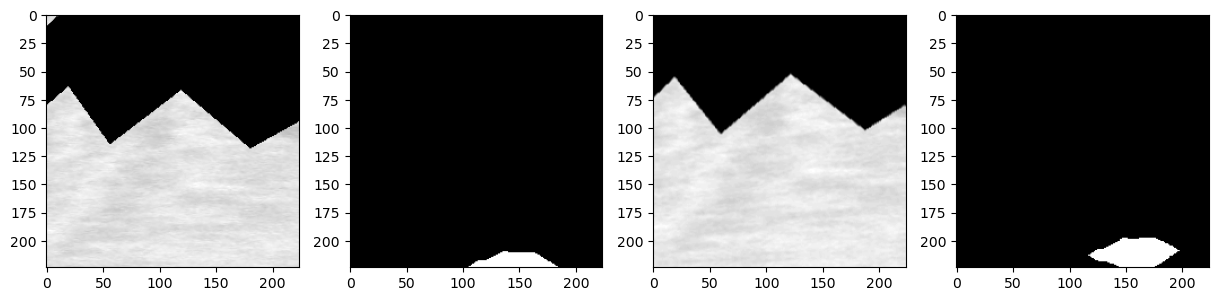

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48125

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096600099406374
th: 0.15, fbeta: 0.12096857866548633
th: 0.2, fbeta: 0.15733851521451359
th: 0.25, fbeta: 0.22880123006347064
th: 0.3, fbeta: 0.279184542328262
th: 0.35, fbeta: 0.3266002928086194
th: 0.4, fbeta: 0.36537229051998293
th: 0.45, fbeta: 0.39032972248933767


best_th: 0.5, fbeta: 0.39532229530938123
Epoch 1 - avg_train_loss: 0.5502  avg_val_loss: 0.3947  time: 146s
Epoch 1 - avgScore: 0.3953
Epoch 1 - Save Best Score: 0.3953 Model
Epoch 1 - Save Best Loss: 0.3947 Model


th: 0.5, fbeta: 0.39532229530938123


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1209707164266484
th: 0.15, fbeta: 0.20109379539992506
th: 0.2, fbeta: 0.23289156859342736
th: 0.25, fbeta: 0.29599839612555484
th: 0.3, fbeta: 0.3395903308284958
th: 0.35, fbeta: 0.36884741929150994
th: 0.4, fbeta: 0.3938934818916862
th: 0.45, fbeta: 0.41424744222153315


best_th: 0.5, fbeta: 0.43116935884276164
Epoch 2 - avg_train_loss: 0.3759  avg_val_loss: 0.3411  time: 149s
Epoch 2 - avgScore: 0.4312
Epoch 2 - Save Best Score: 0.4312 Model
Epoch 2 - Save Best Loss: 0.3411 Model


th: 0.5, fbeta: 0.43116935884276164


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.35552708693816293
th: 0.15, fbeta: 0.41022725652402725
th: 0.2, fbeta: 0.4449442244989012
th: 0.25, fbeta: 0.4614334426905016
th: 0.3, fbeta: 0.46545651045162195
th: 0.35, fbeta: 0.4634027030614197
th: 0.4, fbeta: 0.4530276447244608
th: 0.45, fbeta: 0.43890166337338027


best_th: 0.3, fbeta: 0.46545651045162195
Epoch 3 - avg_train_loss: 0.2788  avg_val_loss: 0.2502  time: 149s
Epoch 3 - avgScore: 0.4655
Epoch 3 - Save Best Score: 0.4655 Model
Epoch 3 - Save Best Loss: 0.2502 Model


th: 0.5, fbeta: 0.42212704540325996


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2710634159174846
th: 0.15, fbeta: 0.2911627461724023
th: 0.2, fbeta: 0.3102964152956183
th: 0.25, fbeta: 0.32743566375637057
th: 0.3, fbeta: 0.34341554525950396
th: 0.35, fbeta: 0.3597008789669978
th: 0.4, fbeta: 0.3760739495786926
th: 0.45, fbeta: 0.392364241275372


best_th: 0.5, fbeta: 0.4081114208754979
Epoch 4 - avg_train_loss: 0.2392  avg_val_loss: 0.2810  time: 148s
Epoch 4 - avgScore: 0.4081


th: 0.5, fbeta: 0.4081114208754979


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.324471988301006
th: 0.15, fbeta: 0.3455073890592927
th: 0.2, fbeta: 0.3628842807199407
th: 0.25, fbeta: 0.376440191881082
th: 0.3, fbeta: 0.38871439977667466
th: 0.35, fbeta: 0.39581025280377524
th: 0.4, fbeta: 0.40308170113201774
th: 0.45, fbeta: 0.4061391476860992


best_th: 0.45, fbeta: 0.4061391476860992
Epoch 5 - avg_train_loss: 0.2266  avg_val_loss: 0.2558  time: 149s
Epoch 5 - avgScore: 0.4061


th: 0.5, fbeta: 0.40036891166392785


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3990109534850985
th: 0.15, fbeta: 0.43529591122180766
th: 0.2, fbeta: 0.4620012867464527
th: 0.25, fbeta: 0.4859565901731474
th: 0.3, fbeta: 0.5086725808607613
th: 0.35, fbeta: 0.5235751922552904
th: 0.4, fbeta: 0.5338752263726567
th: 0.45, fbeta: 0.5425717007950388


best_th: 0.5, fbeta: 0.544732164111604
Epoch 6 - avg_train_loss: 0.2128  avg_val_loss: 0.2316  time: 150s
Epoch 6 - avgScore: 0.5447
Epoch 6 - Save Best Score: 0.5447 Model
Epoch 6 - Save Best Loss: 0.2316 Model


th: 0.5, fbeta: 0.544732164111604


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3118186846634193
th: 0.15, fbeta: 0.329519486481106
th: 0.2, fbeta: 0.3452489560698068
th: 0.25, fbeta: 0.35843858868340345
th: 0.3, fbeta: 0.37304175613296037
th: 0.35, fbeta: 0.3874147469792004
th: 0.4, fbeta: 0.4026779310120434
th: 0.45, fbeta: 0.41743435270895557


best_th: 0.5, fbeta: 0.4338981440916777
Epoch 7 - avg_train_loss: 0.2025  avg_val_loss: 0.2756  time: 149s
Epoch 7 - avgScore: 0.4339


th: 0.5, fbeta: 0.4338981440916777


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4145840786671587
th: 0.15, fbeta: 0.4442154172321588
th: 0.2, fbeta: 0.4653136385380401
th: 0.25, fbeta: 0.4832949604360705
th: 0.3, fbeta: 0.4952943407536292
th: 0.35, fbeta: 0.5052100707229923
th: 0.4, fbeta: 0.512236166370197
th: 0.45, fbeta: 0.5165309510117793


best_th: 0.45, fbeta: 0.5165309510117793
Epoch 8 - avg_train_loss: 0.1910  avg_val_loss: 0.2481  time: 148s
Epoch 8 - avgScore: 0.5165


th: 0.5, fbeta: 0.5160378198382448


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39655103084823945
th: 0.15, fbeta: 0.43185105677077784
th: 0.2, fbeta: 0.4630817201305402
th: 0.25, fbeta: 0.488045168052731
th: 0.3, fbeta: 0.5083453739788406
th: 0.35, fbeta: 0.5222452971942546
th: 0.4, fbeta: 0.5319501008517598
th: 0.45, fbeta: 0.5349955311790163


best_th: 0.45, fbeta: 0.5349955311790163
Epoch 9 - avg_train_loss: 0.1833  avg_val_loss: 0.2515  time: 149s
Epoch 9 - avgScore: 0.5350


th: 0.5, fbeta: 0.5288131343315832


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37623511049685143
th: 0.15, fbeta: 0.41262773939157776
th: 0.2, fbeta: 0.4423685571308186
th: 0.25, fbeta: 0.471163928947429
th: 0.3, fbeta: 0.4909209759237445
th: 0.35, fbeta: 0.509190892945111
th: 0.4, fbeta: 0.5268741683266563
th: 0.45, fbeta: 0.5387607700370941


best_th: 0.5, fbeta: 0.5453721279629763
Epoch 10 - avg_train_loss: 0.1716  avg_val_loss: 0.2345  time: 150s
Epoch 10 - avgScore: 0.5454
Epoch 10 - Save Best Score: 0.5454 Model
Epoch 10 - Save Best Loss: 0.2345 Model


th: 0.5, fbeta: 0.5453721279629763


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4141431371232707
th: 0.15, fbeta: 0.4439489935020159
th: 0.2, fbeta: 0.4674048958012158
th: 0.25, fbeta: 0.48843883488188633
th: 0.3, fbeta: 0.5083383774650723
th: 0.35, fbeta: 0.5251744090754837
th: 0.4, fbeta: 0.5383635260161183
th: 0.45, fbeta: 0.5506350693933566


best_th: 0.5, fbeta: 0.5607114568480684
Epoch 11 - avg_train_loss: 0.1648  avg_val_loss: 0.2493  time: 149s
Epoch 11 - avgScore: 0.5607
Epoch 11 - Save Best Score: 0.5607 Model
Epoch 11 - Save Best Loss: 0.2493 Model


th: 0.5, fbeta: 0.5607114568480684


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.371634340252613
th: 0.15, fbeta: 0.40132427665098874
th: 0.2, fbeta: 0.4256277120717407
th: 0.25, fbeta: 0.4490406324210764
th: 0.3, fbeta: 0.46906931080458203
th: 0.35, fbeta: 0.4866643154054765
th: 0.4, fbeta: 0.5026285863508391
th: 0.45, fbeta: 0.5187723445756356


best_th: 0.5, fbeta: 0.5335448610662158
Epoch 12 - avg_train_loss: 0.1571  avg_val_loss: 0.2524  time: 148s
Epoch 12 - avgScore: 0.5335


th: 0.5, fbeta: 0.5335448610662158


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36362145904285764
th: 0.15, fbeta: 0.39286366616892016
th: 0.2, fbeta: 0.4168465343273492
th: 0.25, fbeta: 0.4370711227637922
th: 0.3, fbeta: 0.4571570112294212
th: 0.35, fbeta: 0.4759551959406247
th: 0.4, fbeta: 0.49267548459469584
th: 0.45, fbeta: 0.5058832242857263


best_th: 0.5, fbeta: 0.5178980799999157
Epoch 13 - avg_train_loss: 0.1467  avg_val_loss: 0.2615  time: 149s
Epoch 13 - avgScore: 0.5179


th: 0.5, fbeta: 0.5178980799999157


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38691430387707176
th: 0.15, fbeta: 0.41510182008923396
th: 0.2, fbeta: 0.43843215550546877
th: 0.25, fbeta: 0.46066264889637
th: 0.3, fbeta: 0.4804012296842345
th: 0.35, fbeta: 0.4965148750725944
th: 0.4, fbeta: 0.5064805746280816
th: 0.45, fbeta: 0.5103796868968725


best_th: 0.45, fbeta: 0.5103796868968725
Epoch 14 - avg_train_loss: 0.1389  avg_val_loss: 0.2639  time: 148s
Epoch 14 - avgScore: 0.5104


th: 0.5, fbeta: 0.5102062087803316


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4425868263834052
th: 0.15, fbeta: 0.47110654547299274
th: 0.2, fbeta: 0.4900017004008094
th: 0.25, fbeta: 0.506142795854431
th: 0.3, fbeta: 0.5197067502143927
th: 0.35, fbeta: 0.5306986306310217
th: 0.4, fbeta: 0.5380557157068703
th: 0.45, fbeta: 0.5396492282481595


best_th: 0.45, fbeta: 0.5396492282481595
Epoch 15 - avg_train_loss: 0.1299  avg_val_loss: 0.2776  time: 149s
Epoch 15 - avgScore: 0.5396


th: 0.5, fbeta: 0.5369384691383746


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39780669587506423
th: 0.15, fbeta: 0.427909934979808
th: 0.2, fbeta: 0.45262906284647353
th: 0.25, fbeta: 0.4749351927342413
th: 0.3, fbeta: 0.49540497978889453
th: 0.35, fbeta: 0.5110248292395826
th: 0.4, fbeta: 0.5238108645151647
th: 0.45, fbeta: 0.5312445493192781


best_th: 0.5, fbeta: 0.5361340779231352
Epoch 16 - avg_train_loss: 0.1241  avg_val_loss: 0.2788  time: 149s
Epoch 16 - avgScore: 0.5361


th: 0.5, fbeta: 0.5361340779231352


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41643445569243537
th: 0.15, fbeta: 0.4380486284600845
th: 0.2, fbeta: 0.4561772490732363
th: 0.25, fbeta: 0.47365651923548296
th: 0.3, fbeta: 0.4893569549072763
th: 0.35, fbeta: 0.5006194509520138
th: 0.4, fbeta: 0.5107442734226761
th: 0.45, fbeta: 0.5176589856653794


best_th: 0.5, fbeta: 0.5225017422501463
Epoch 17 - avg_train_loss: 0.1171  avg_val_loss: 0.3043  time: 151s
Epoch 17 - avgScore: 0.5225


th: 0.5, fbeta: 0.5225017422501463


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4211690746081645
th: 0.15, fbeta: 0.447149680943401
th: 0.2, fbeta: 0.4666613187946722
th: 0.25, fbeta: 0.4816058075141824
th: 0.3, fbeta: 0.4951308161056373
th: 0.35, fbeta: 0.5063471691464799
th: 0.4, fbeta: 0.5145322774311712
th: 0.45, fbeta: 0.5195148362026202


best_th: 0.5, fbeta: 0.5235609472183274
Epoch 18 - avg_train_loss: 0.1109  avg_val_loss: 0.3049  time: 149s
Epoch 18 - avgScore: 0.5236


th: 0.5, fbeta: 0.5235609472183274


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40043207988411134
th: 0.15, fbeta: 0.4223343037011018
th: 0.2, fbeta: 0.44388765580336065
th: 0.25, fbeta: 0.463771675707248
th: 0.3, fbeta: 0.47947896701206866
th: 0.35, fbeta: 0.49284676301468566
th: 0.4, fbeta: 0.5034666830765971
th: 0.45, fbeta: 0.5113399741770241


best_th: 0.5, fbeta: 0.5168065242938962
Epoch 19 - avg_train_loss: 0.1069  avg_val_loss: 0.2936  time: 149s
Epoch 19 - avgScore: 0.5168


th: 0.5, fbeta: 0.5168065242938962


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36872701636465566
th: 0.15, fbeta: 0.3947792506743769
th: 0.2, fbeta: 0.417504216152091
th: 0.25, fbeta: 0.4368259053669744
th: 0.3, fbeta: 0.4567932926917035
th: 0.35, fbeta: 0.47606369266666443
th: 0.4, fbeta: 0.4951228000325461
th: 0.45, fbeta: 0.5115478966396843


best_th: 0.5, fbeta: 0.5249604351083185
Epoch 20 - avg_train_loss: 0.1021  avg_val_loss: 0.2902  time: 149s
Epoch 20 - avgScore: 0.5250


th: 0.5, fbeta: 0.5249604351083185


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4058001169955382
th: 0.15, fbeta: 0.43469282854453095
th: 0.2, fbeta: 0.46214732168998957
th: 0.25, fbeta: 0.4838348069841169
th: 0.3, fbeta: 0.5015202431717444
th: 0.35, fbeta: 0.5165194831563013
th: 0.4, fbeta: 0.5273982013364867
th: 0.45, fbeta: 0.5338047402267896


best_th: 0.5, fbeta: 0.5370460715368145
Epoch 21 - avg_train_loss: 0.0965  avg_val_loss: 0.2892  time: 150s
Epoch 21 - avgScore: 0.5370


th: 0.5, fbeta: 0.5370460715368145


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4244029580706722
th: 0.15, fbeta: 0.4530596550411946
th: 0.2, fbeta: 0.4767626741134697
th: 0.25, fbeta: 0.4945323457081981
th: 0.3, fbeta: 0.5098788440639276
th: 0.35, fbeta: 0.5217176395296563
th: 0.4, fbeta: 0.5311507598629838
th: 0.45, fbeta: 0.537019302523563


best_th: 0.45, fbeta: 0.537019302523563
Epoch 22 - avg_train_loss: 0.0923  avg_val_loss: 0.3274  time: 149s
Epoch 22 - avgScore: 0.5370


th: 0.5, fbeta: 0.5361687770068141


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4043942215599449
th: 0.15, fbeta: 0.43684701235314155
th: 0.2, fbeta: 0.4633214146018428
th: 0.25, fbeta: 0.483497845551572
th: 0.3, fbeta: 0.5016144352542748
th: 0.35, fbeta: 0.5155971412407038
th: 0.4, fbeta: 0.5257996398568897
th: 0.45, fbeta: 0.5327707312735945


best_th: 0.5, fbeta: 0.5377887657489775
Epoch 23 - avg_train_loss: 0.0883  avg_val_loss: 0.3112  time: 148s
Epoch 23 - avgScore: 0.5378


th: 0.5, fbeta: 0.5377887657489775


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42607585986487706
th: 0.15, fbeta: 0.4534913326726415
th: 0.2, fbeta: 0.47664652695242393
th: 0.25, fbeta: 0.49706054768988134
th: 0.3, fbeta: 0.5125460566030873
th: 0.35, fbeta: 0.5229169672075202
th: 0.4, fbeta: 0.5298454513277692
th: 0.45, fbeta: 0.5362469683126633


best_th: 0.5, fbeta: 0.5386093744428229
Epoch 24 - avg_train_loss: 0.0860  avg_val_loss: 0.3103  time: 148s
Epoch 24 - avgScore: 0.5386


th: 0.5, fbeta: 0.5386093744428229


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45955664559392656
th: 0.15, fbeta: 0.4866786969715077
th: 0.2, fbeta: 0.510330345519277
th: 0.25, fbeta: 0.5274097485797303
th: 0.3, fbeta: 0.539039500559567
th: 0.35, fbeta: 0.5450918280495896
th: 0.4, fbeta: 0.5467725865841847
th: 0.45, fbeta: 0.5480844795952806


best_th: 0.45, fbeta: 0.5480844795952806
Epoch 25 - avg_train_loss: 0.0826  avg_val_loss: 0.3401  time: 149s
Epoch 25 - avgScore: 0.5481


th: 0.5, fbeta: 0.5468344287855906


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4308557072529991
th: 0.15, fbeta: 0.4565389486857797
th: 0.2, fbeta: 0.4775646214628487
th: 0.25, fbeta: 0.4962339276477488
th: 0.3, fbeta: 0.5084227837274259
th: 0.35, fbeta: 0.5198338707974562
th: 0.4, fbeta: 0.530901121670433
th: 0.45, fbeta: 0.536833998764257


best_th: 0.5, fbeta: 0.5391643518240045
Epoch 26 - avg_train_loss: 0.0802  avg_val_loss: 0.3378  time: 149s
Epoch 26 - avgScore: 0.5392


th: 0.5, fbeta: 0.5391643518240045


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40646616391781065
th: 0.15, fbeta: 0.42858111986836395
th: 0.2, fbeta: 0.45042044522845537
th: 0.25, fbeta: 0.4708026723883322
th: 0.3, fbeta: 0.48663429224339794
th: 0.35, fbeta: 0.5013327228227836
th: 0.4, fbeta: 0.5128876130244719
th: 0.45, fbeta: 0.5220694709795897


best_th: 0.5, fbeta: 0.5268534019078018
Epoch 27 - avg_train_loss: 0.0784  avg_val_loss: 0.3314  time: 149s
Epoch 27 - avgScore: 0.5269


th: 0.5, fbeta: 0.5268534019078018


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42538528776299656
th: 0.15, fbeta: 0.45136741613988945
th: 0.2, fbeta: 0.4725140806482586
th: 0.25, fbeta: 0.48991378271909536
th: 0.3, fbeta: 0.503018980610105
th: 0.35, fbeta: 0.5143107924576404
th: 0.4, fbeta: 0.5225698319811544
th: 0.45, fbeta: 0.5281132642022969


best_th: 0.5, fbeta: 0.5289677280939725
Epoch 28 - avg_train_loss: 0.0768  avg_val_loss: 0.3598  time: 149s
Epoch 28 - avgScore: 0.5290


th: 0.5, fbeta: 0.5289677280939725


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4121881934331821
th: 0.15, fbeta: 0.4347716050318799
th: 0.2, fbeta: 0.45527293114616574
th: 0.25, fbeta: 0.4717958049642336
th: 0.3, fbeta: 0.4861869868886056
th: 0.35, fbeta: 0.4983360673386606
th: 0.4, fbeta: 0.5070961526249472
th: 0.45, fbeta: 0.5138206250898968


best_th: 0.5, fbeta: 0.5165830298996309
Epoch 29 - avg_train_loss: 0.0747  avg_val_loss: 0.3582  time: 149s
Epoch 29 - avgScore: 0.5166


th: 0.5, fbeta: 0.5165830298996309


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4216548155898593
th: 0.15, fbeta: 0.4471166556531166
th: 0.2, fbeta: 0.4697562514425773
th: 0.25, fbeta: 0.48895651702977194
th: 0.3, fbeta: 0.5017222136918305
th: 0.35, fbeta: 0.5114916528783334
th: 0.4, fbeta: 0.5175731574773477
th: 0.45, fbeta: 0.5214048237298232


best_th: 0.5, fbeta: 0.5229525897617517
Epoch 30 - avg_train_loss: 0.0736  avg_val_loss: 0.3539  time: 149s
Epoch 30 - avgScore: 0.5230


th: 0.5, fbeta: 0.5229525897617517


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4141431371232707
th: 0.15, fbeta: 0.4439489935020159
th: 0.2, fbeta: 0.4674048958012158
th: 0.25, fbeta: 0.48843883488188633
th: 0.3, fbeta: 0.5083383774650723
th: 0.35, fbeta: 0.5251744090754837
th: 0.4, fbeta: 0.5383635260161183
th: 0.45, fbeta: 0.5506350693933566


best_th: 0.5, fbeta: 0.5607114568480684


th: 0.5, fbeta: 0.5607114568480684


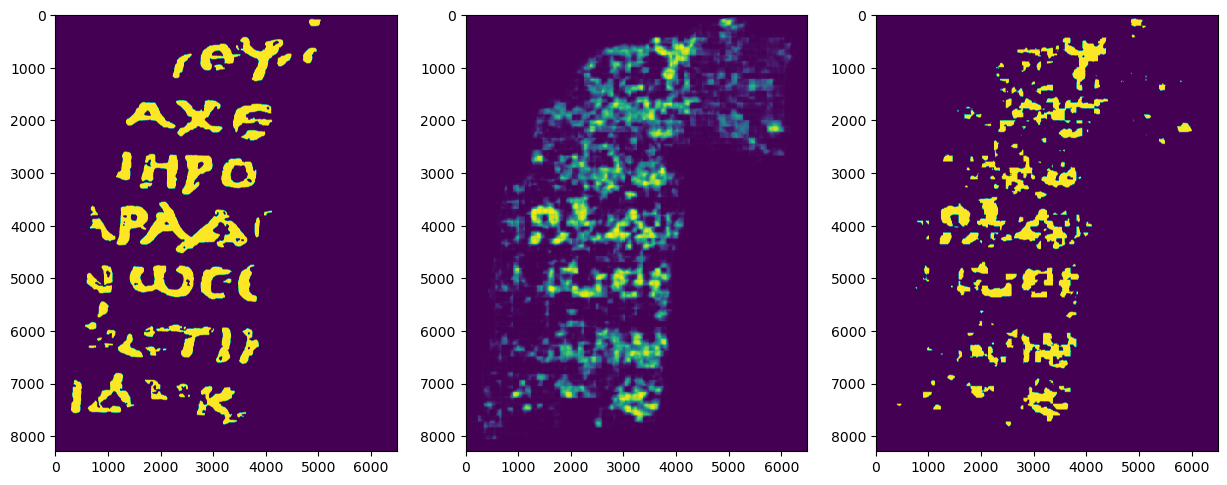

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([40545937.,  2333726.,  1520409.,  1127303.,   948403.,   852484.,
          777021.,   697996.,   666732.,   614474.,   546803.,   521981.,
          482052.,   433356.,   363113.,   335479.,   309752.,   294740.,
          299653.,   167434.]),
 array([7.03237788e-07, 4.99054191e-02, 9.98101350e-02, 1.49714851e-01,
        1.99619567e-01, 2.49524283e-01, 2.99428998e-01, 3.49333714e-01,
        3.99238430e-01, 4.49143146e-01, 4.99047862e-01, 5.48952578e-01,
        5.98857294e-01, 6.48762010e-01, 6.98666725e-01, 7.48571441e-01,
        7.98476157e-01, 8.48380873e-01, 8.98285589e-01, 9.48190305e-01,
        9.98095021e-01]),
 <BarContainer object of 20 artists>)

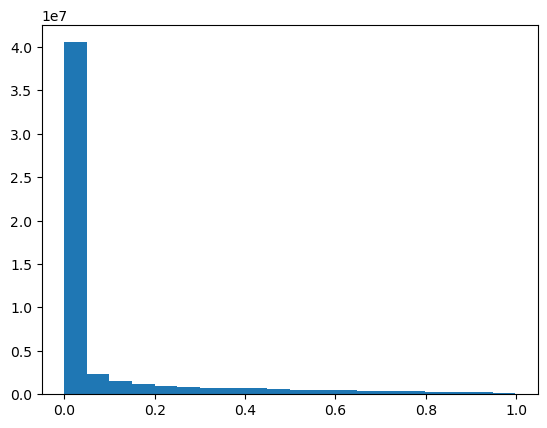

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000